# Amazon Estuary Exploration:
## Cloud Direct Download Version

This tutorial is one of two jupyter notebook versions of the same use case exploring multiple satellite data products over the Amazon Estuary. In this version, we use data that has been downloaded onto our local machine from the cloud. 

### Learning Objectives
 - Compare cloud access methods (in tandem with notebook "Amazon Estuary Exploration: In Cloud AWS Version")
 - Search for data products using Earthdata Search GUI
 - Access datasets using xarray and visualize using hvplot or plot tools

This tutorial explores the relationships between river height, land water equivalent thickness, sea surface salinity, and sea surface temperature in the Amazon River estuary and coastal region from multiple datasets listed below. The contents are useful for the ocean, coastal, and terrestrial hydrosphere communities, showcasing how to use cloud datasets and services. This notebook is meant to be executed locally.

## Cloud Datasets
The tutorial itself will use four different datasets: 

1\. **TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2** 
    
>DOI: [https://doi.org/10.5067/TEMSC-3JC62](https://doi.org/10.5067/TEMSC-3JC62) 
   
    The Gravity Recovery And Climate Experiment Follow-On (GRACE-FO) satellite land water equivalent (LWE) thicknesses will be used to observe seasonal changes in water storage around the river. When discharge is high, the change in water storage will increase, thus highlighting a wet season. 


2\. **PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2** 

>DOI: [https://doi.org/10.5067/PSGRA-DA2V2](https://doi.org/10.5067/PSGRA-DA2V2)
   
    The NASA Pre-SWOT Making Earth System Data Records for Use in Research Environments (MEaSUREs) Program virtual gauges will be used as a proxy for Surface Water and Ocean Topography (SWOT) discharge until SWOT products are available. MEaSUREs contains river height products, not discharge, but river height is directly related to discharge and thus will act as a good substitute.


3\. **OISSS_L4_multimission_7day_v1** 
    
>DOI: [https://doi.org/10.5067/SMP10-4U7CS](https://doi.org/10.5067/SMP10-4U7CS) 
   
    Optimally Interpolated Sea surface salinity (OISSS) is a level 4 product that combines the records from Aquarius (Sept 2011-June 2015), the Soil Moisture Active Passive (SMAP) satellite (April 2015-present), and ESAs Soil Moisture Ocean Salinity (SMOS) data to fill in data gaps.

   
4\. **MODIS_AQUA_L3_SST_MID-IR_MONTHLY_9KM_NIGHTTIME_V2019.0**
   
>DOI: [https://doi.org/10.5067/MODAM-MO9N9](https://doi.org/10.5067/MODAM-MO9N9)
    
    Sea surface temperature is obtained from the Moderate Resolution Imaging Spectrometer (MODIS) instrument on board the Aqua satellite. 

More details on available collections are on the [PO.DAAC Cloud Earthdata Search Portal](https://search.earthdata.nasa.gov/portal/podaac-cloud/search). For more information on the PO.DAAC transition to the cloud, please visit: https://podaac.jpl.nasa.gov/cloud-datasets/about

#### Note: NASA Earthdata Login Required
An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.


## Needed Packages

In [1]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import hvplot.xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from datetime import datetime
from os.path import isfile, basename, abspath
import dask
dask.config.set({"array.slicing.split_large_chunks": False})

## Liquid Water Equivalent (LWE) Thickness (GRACE & GRACE-FO)
#### Search for GRACE LWE Thickness data

Suppose we are interested in LWE data from the dataset (DOI:10.5067/TEMSC-3JC62) described on this PO.DAAC dataset landing page: 
https://podaac.jpl.nasa.gov/dataset/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2

From the landing page, we see the dataset Short Name under the Information tab. (For this dataset it is "TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2") Copy that to paste and search later. Log in to your Earthdata account at: https://search.earthdata.nasa.gov. Enter the Short Name and search. Clicking on one of the search results brings us to a list of granules. Within that URL, we can grab the concept-id, a string starting with "C" and ending with "-POCLOUD". For this dataset, it is "C1938032626-POCLOUD". We directly download the single granule of data by following the prompts and open it on our local machine using xarray below.



#### Open file using xarray.

In [2]:
ds_GRACE = xr.open_dataset('GRCTellus.JPL.200204_202112.GLO.RL06M.MSCNv02CRI.nc') 
ds_GRACE

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 204, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-12-16T1...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2022-01-31T20:01:59Z

#### Plot a subset of the data
Use the function `xarray.DataSet.sel` to select a subset of the data to plot with `hvplot`. 

In [3]:
lat_bnds, lon_bnds = [-18, 10], [275, 330] #degrees east for longitude
ds_GRACE_subset = ds_GRACE.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))
ds_GRACE_subset

ds_GRACE_subset.lwe_thickness.hvplot.image(y='lat', x='lon', cmap='bwr_r',).opts(clim=(-80,80))

:DynamicMap   [time]
   :Image   [lon,lat]   (lwe_thickness)

## River heights (Pre-SWOT MEaSUREs)
The shortname for MEaSUREs is 'PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2' with the concept ID: C2036882359-POCLOUD.

For this dataset, we downloaded the cloud-enabled data directly using the Earthdata Search [(see the Earthdata Search for downloading data tutorial)](https://github.com/podaac/tutorials/blob/master/notebooks/batch_download_podaac_data.md) by searching directly for the concept ID. By using the gui, we download the granule needed, G2105958903-POCLOUD, that will show us the Amazon river. 

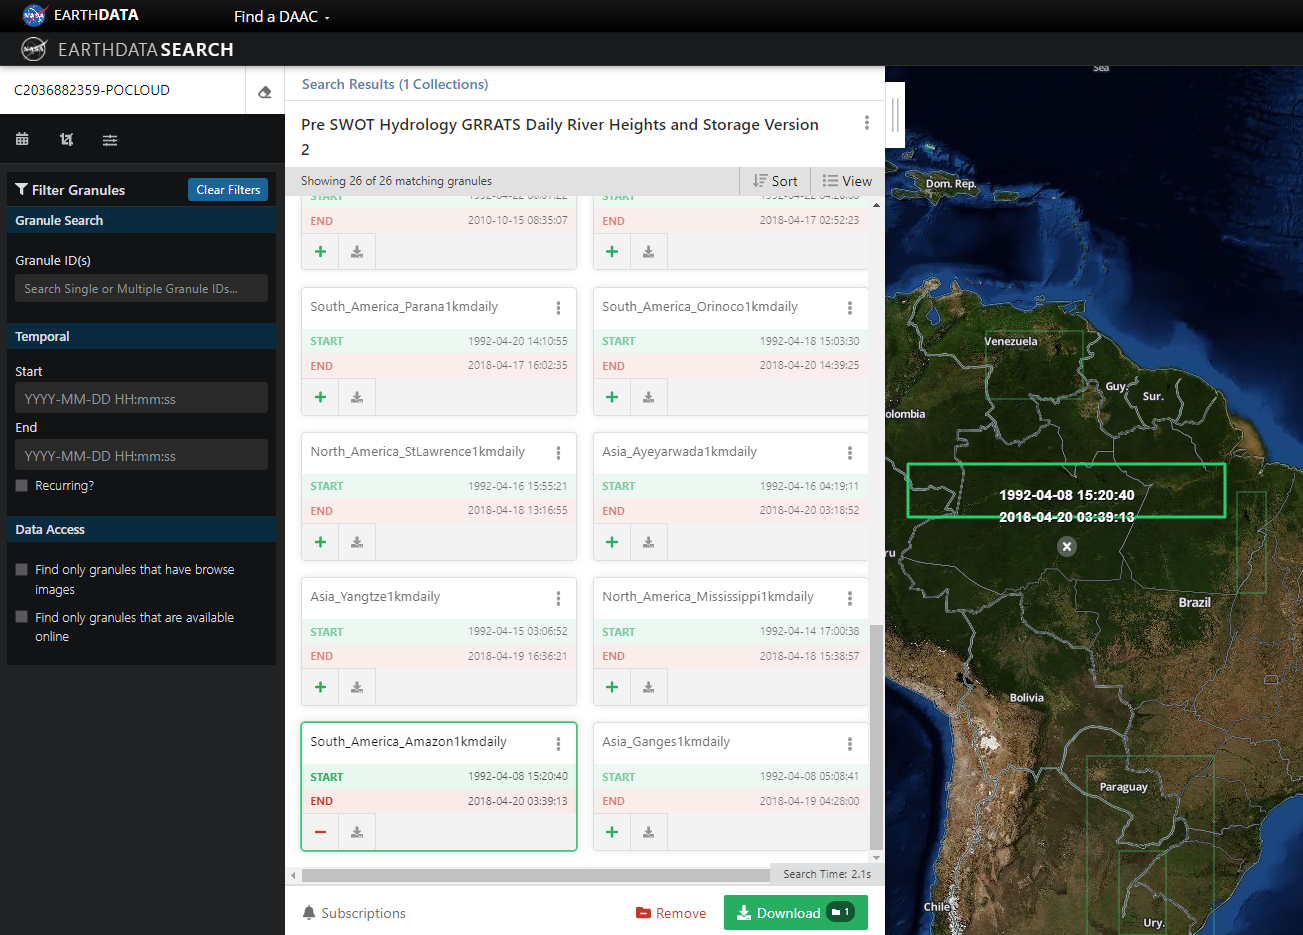


The [guidebook](https://podaac-tools.jpl.nasa.gov/drive/files/allData/preswot_hydrology/L2/rivers/docs/GRRATS_user_handbookV2.pdf) explains the details of the Pre-SWOT MEaSUREs data.

Our desired variable is height (meters above EGM2008 geoid) for this exercise, which can be subset by distance and time. Distance represents the distance from the river mouth, in this example, the Amazon estuary. Time is between April 8, 1993 and April 20, 2019.

Let's look at this example file to see how the data is organized:

In [4]:
ds_MEaSUREs = xr.open_dataset('South_America_Amazon1kmdaily.nc')
ds_MEaSUREs

<xarray.Dataset>
Dimensions:              (X: 3311, Y: 3311, distance: 3311, time: 9469, charlength: 26)
Coordinates:
  * time                 (time) datetime64[ns] 1993-04-08T15:20:40.665117184 ...
Dimensions without coordinates: X, Y, distance, charlength
Data variables:
    lon                  (X) float64 ...
    lat                  (Y) float64 ...
    FD                   (distance) float64 ...
    height               (distance, time) float64 ...
    sat                  (charlength, time) |S1 ...
    storage              (distance, time) float64 ...
    IceFlag              (time) float64 ...
    LakeFlag             (distance) float64 ...
    Storage_uncertainty  (distance, time) float64 ...
Attributes: (12/40)
    title:                         GRRATS (Global River Radar Altimetry Time ...
    Conventions:                   CF-1.6, ACDD-1.3
    institution:                   Ohio State University, School of Earth Sci...
    source:                        MEaSUREs OSU Storage toolbox 2018
    keywords:                      EARTH SCIENCE,TERRESTRIAL HYDROSPHERE,SURF...
    keywords_vocabulary:           Global Change Master Directory (GCMD)
    ...                            ...
    geospatial_lat_max:            -0.6550700975069503
    geospatial_lat_units:          degree_north
    geospatial_vertical_max:       92.7681246287056
    geospatial_vertical_min:       -3.5634095181633763
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up

#### Plot a subset of the data
Plotting the river distances and associated heights on the map at time t=9069 (March 16, 2018) using `plt`.

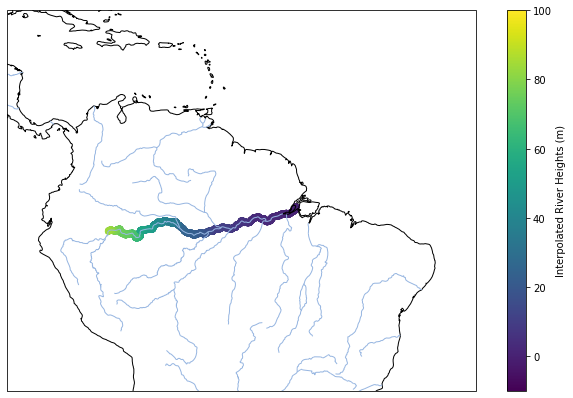

In [5]:
fig = plt.figure(figsize=[11,7]) 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-85, -30, -20, 20])
ax.add_feature(cartopy.feature.RIVERS)

plt.scatter(ds_MEaSUREs.lon, ds_MEaSUREs.lat, lw=1, c=ds_MEaSUREs.height[:,9069])
plt.colorbar(label='Interpolated River Heights (m)')
plt.clim(-10,100)

plt.show()

## Sea Surface Salinity (Multi-mission: SMAP, Aquarius, SMOS)

The shortname for this dataset is 'OISSS_L4_multimission_7day_v1' with the concept ID: C2095055342-POCLOUD. This dataset contains hundreds of granules, so we will need to download multiple at once instead of one single file like the previous two datasets. By using Earthdata Search, we access 917 granules (1.1 GB) and click 'Download All":

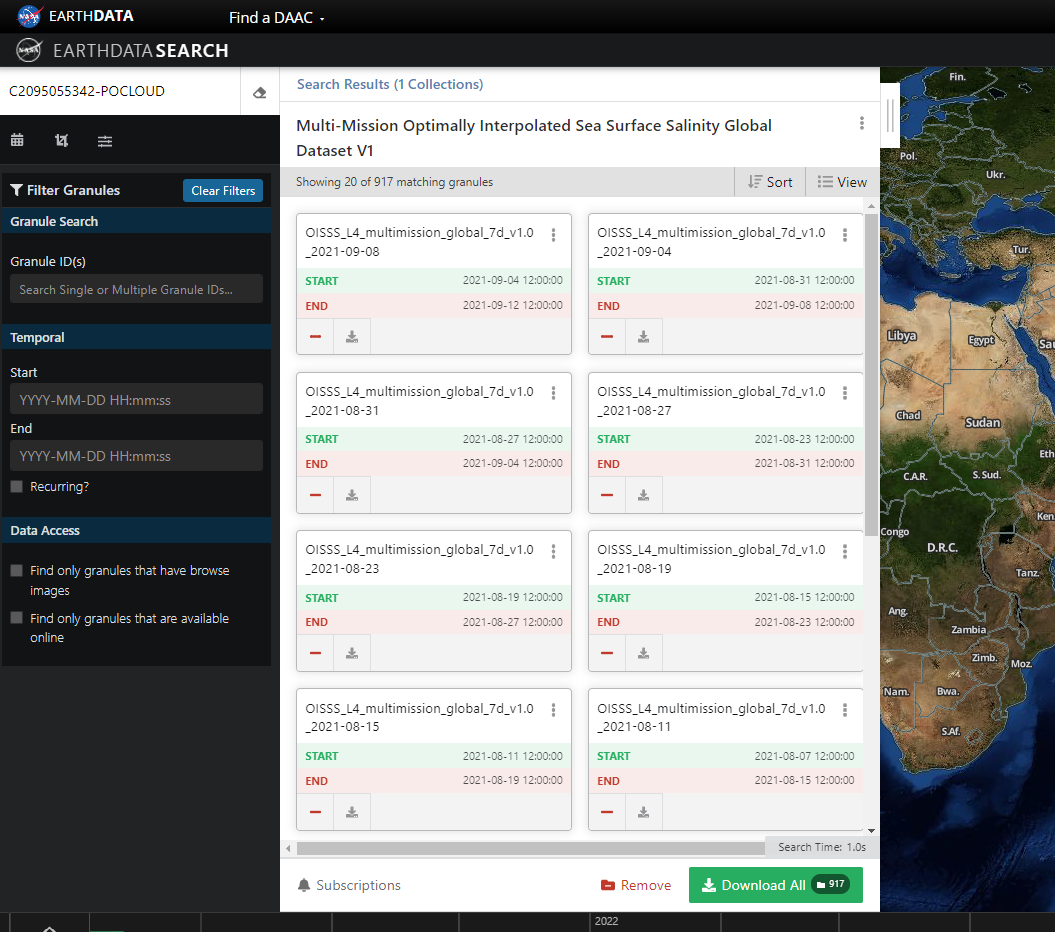

From here, we downloaded the data to our local machine via the given script for the links list:

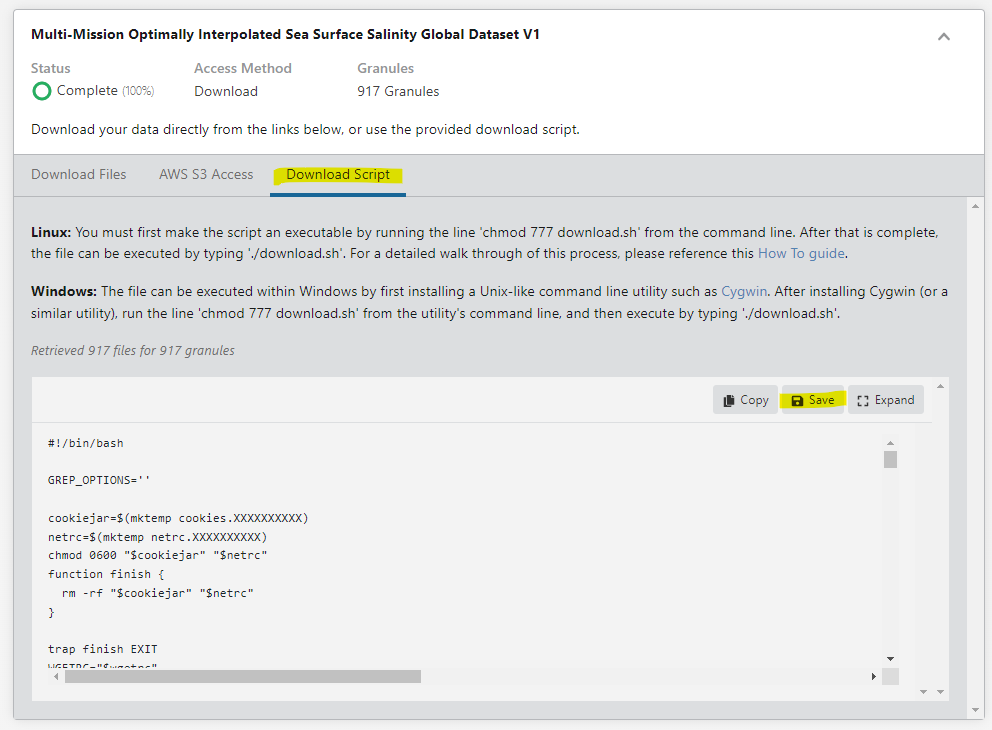

Next, get a list of files so we can open them all at once, creating an `xarray dataset` using the `open_mfdataset()` function to "read in" all of the netCDF4 files in one call.

In [6]:
SSS_file_list = glob.glob('OISSS/OISSS*.nc')
len(SSS_file_list)

917

In [7]:
ds_sss = xr.open_mfdataset(SSS_file_list,
                           combine='by_coords',
                           mask_and_scale=True,
                           decode_cf=True,
                           chunks='auto')
ds_sss

<xarray.Dataset>
Dimensions:          (longitude: 1440, latitude: 720, time: 917)
Coordinates:
  * longitude        (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * latitude         (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * time             (time) datetime64[ns] 2011-08-28 2011-09-01 ... 2021-09-08
Data variables:
    sss              (latitude, longitude, time) float32 dask.array<chunksize=(720, 1440, 1), meta=np.ndarray>
    sss_uncertainty  (latitude, longitude, time) float32 dask.array<chunksize=(720, 1440, 1), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      CF Standard Name Table v27
    Title:                         Multi-Mission Optimally Interpolated Sea S...
    Short_Name:                    OISSS_L4_multimission_7d_v1
    Version:                       V1.0
    Processing_Level:              Level 4
    ...                            ...
    geospatial_lat_resolution:     0.25
    geospatial_lat_units:          degrees_north
    geospatial_lon_min:            -180.0
    geospatial_lon_max:            180.0
    geospatial_lon_resolution:     0.25
    geospatial_lon_units:          degrees_east

#### Plot a subset of the data
Use the function `xarray.DataSet.sel` to select a subset of the data at the outlet of the Amazon to plot at time t=0 (August 28, 2011) with `hvplot`. 

In [8]:
lat_bnds, lon_bnds = [-2, 6], [-52, -44] 
ds_sss_subset = ds_sss.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))
ds_sss_subset

ds_sss_subset.sss[:,:,0].hvplot() 

:Image   [longitude,latitude]   (sss)

## Sea Surface Temperature (MODIS)

MODIS has SST data with separate files on a monthly basis. By using Earthdata Search with the shortname: "MODIS_AQUA_L3_SST_MID-IR_MONTHLY_9KM_NIGHTTIME_V2019.0", and filtering by time to coincide when SSS started (2011), we access 130 granules (943 MB) and download using the same method as previously used for SSS.

Get a list of files so we can open them all at once, creating an `xarray dataset` using the `open_mfdataset()` function to "read in" all of the netCDF4 files in one call. MODIS does not have a built-in time variable like SSS, but it is subset by latitude and longitude coordinates. We need to combine the files using the nested format with a created 'time' dimension.

In [9]:
SST_file_list = glob.glob('MODIS_monthly/AQUA*.nc')
len(SST_file_list)

130

MODIS did not come with a time variable, so it needs to be extracted from the file names and added in the file preprocessing so files can be successfully concatenated.

In [10]:
#function for time dimension added to each netCDF file
def preprocessing(ds): 
    file_name = ds.product_name 
    file_date = basename(file_name).split("_")[2][:6]
    file_date_c = datetime.strptime(file_date, "%Y%m")
    time_point = [file_date_c]
    ds.coords['time'] = ('time', time_point) #expand the dimensions to include time
    return ds

ds_MODIS = xr.open_mfdataset(SST_file_list, combine='by_coords', join='override', preprocess = preprocessing)
ds_MODIS

<xarray.Dataset>
Dimensions:    (lat: 2160, lon: 4320, time: 130, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat        (lat) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon        (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * time       (time) datetime64[ns] 2011-01-01 2011-02-01 ... 2021-11-01
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    sst4       (time, lat, lon) float32 dask.array<chunksize=(1, 2160, 4320), meta=np.ndarray>
    qual_sst4  (time, lat, lon) float32 dask.array<chunksize=(1, 2160, 4320), meta=np.ndarray>
    palette    (time, lon, lat, rgb, eightbitcolor) uint8 dask.array<chunksize=(1, 4320, 2160, 3, 256), meta=np.ndarray>
Attributes: (12/59)
    product_name:                     AQUA_MODIS.20110101_20110131.L3m.MO.SST...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    temporal_range:                   month
    ...                               ...
    publisher_url:                    https://oceandata.sci.gsfc.nasa.gov
    processing_level:                 L3 Mapped
    cdm_data_type:                    grid
    data_bins:                        4834400
    data_minimum:                     -1.635
    data_maximum:                     32.06999

# Plot a subset of the data
Use the function `xarray.DataSet.sel` to select a subset of the data at the outlet of the Amazon to plot with `hvplot`. 

In [11]:
lat_bnds, lon_bnds = [6, -2], [-52, -44] 
ds_MODIS_subset = ds_MODIS.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))

ds_MODIS_subset.sst4.hvplot.image(y='lat', x='lon', cmap='viridis').opts(clim=(22,30))

:DynamicMap   [time]
   :Image   [lon,lat]   (sst4)

## Time Series Comparison

Plot each dataset for the time period 2011-2019.

First, we need to average all pixels in the subset lat/lon per time for sea surface salinity and sea surface temperature to set up for the graphs.

In [12]:
sss_mean = []
for t in np.arange(len(ds_sss_subset.time)):
    sss_mean.append(np.nanmean(ds_sss_subset.sss[:,:,t].values))

#sss_mean

In [13]:
#MODIS
sst_MODIS_mean = []
for t in np.arange(len(ds_MODIS_subset.time)):
    sst_MODIS_mean.append(np.nanmean(ds_MODIS_subset.sst4[t,:,:].values))
    
#sst_MODIS_mean

### Combined timeseries plot of river height and LWE thickness

Both datasets are mapped for the outlet of the Amazon River into the estuary.

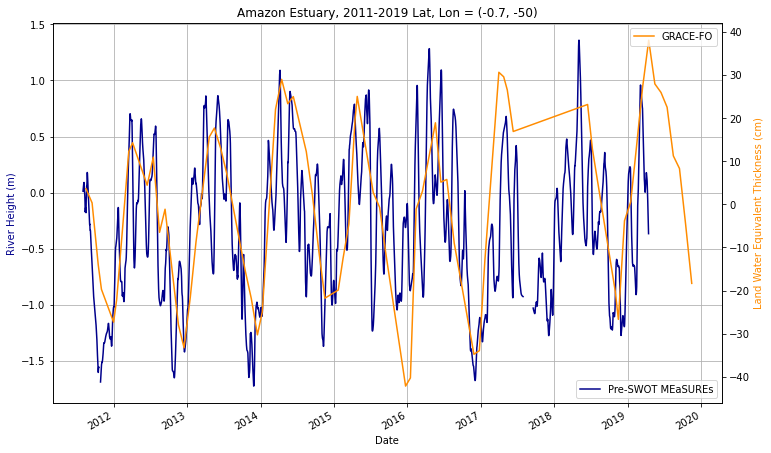

In [14]:
#plot river height and land water equivalent thickness
fig, ax1 = plt.subplots(figsize=[12,7])

#plot river height
ds_MEaSUREs.height[16,6689:9469].plot(color='darkblue')

#plot LWE thickness on secondary axis
ax2 = ax1.twinx()
ax2.plot(ds_GRACE_subset.time[107:179], ds_GRACE_subset.lwe_thickness[107:179,34,69], color = 'darkorange')

ax1.set_xlabel('Date')
ax2.set_ylabel('Land Water Equivalent Thickness (cm)', color='darkorange')
ax1.set_ylabel('River Height (m)', color='darkblue')
ax2.legend(['GRACE-FO'], loc='upper right')
ax1.legend(['Pre-SWOT MEaSUREs'], loc='lower right')

plt.title('Amazon Estuary, 2011-2019 Lat, Lon = (-0.7, -50)')
ax1.grid()
plt.show()

LWE thickness captures the seasonality of Pre-SWOT MEaSUREs river heights well, and so LWE thickness can be compared to all other variables as a representative of the seasonality of both measurements for the purpose of this notebook. 

### Combined timeseries plots of salinity and LWE thickness, followed by temperature

Text(0, 0.5, 'River Height (m)')

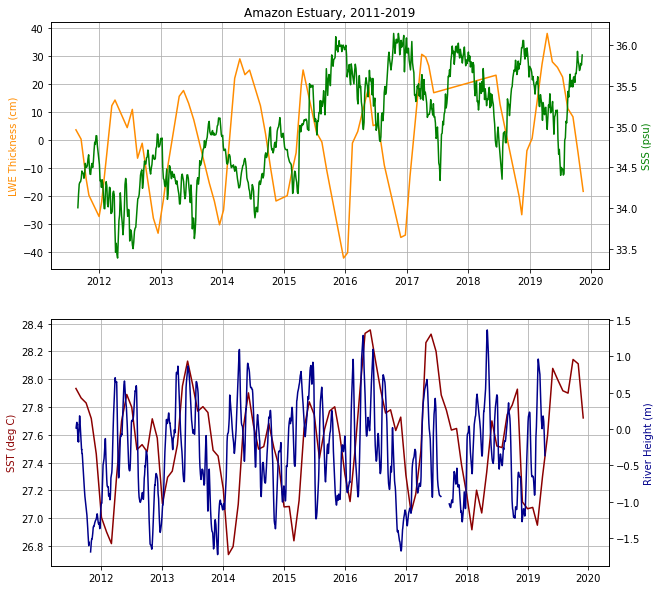

In [15]:
#Combined Subplots
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(211)
plt.title('Amazon Estuary, 2011-2019')
ax2 = ax1.twinx()
ax3 = plt.subplot(212)
ax4 = ax3.twinx()

#lwe thickness
ax1.plot(ds_GRACE_subset.time[107:179], ds_GRACE_subset.lwe_thickness[107:179,34,69], color = 'darkorange')
ax1.set_ylabel('LWE Thickness (cm)', color='darkorange')
ax1.grid()

#sea surface salinity
ax2.plot(ds_sss_subset.time[0:750], sss_mean[0:750], 'g')
ax2.set_ylabel('SSS (psu)', color='g')

#sea surface temperature
ax3.plot(ds_MODIS_subset.time[7:108], sst_MODIS_mean[7:108], 'darkred')
ax3.set_ylabel('SST (deg C)', color='darkred')
ax3.grid()

#river height at outlet
ds_MEaSUREs.height[16,6689:9469].plot(color='darkblue')
ax4.set_ylabel('River Height (m)', color='darkblue')

Measurements of LWE thickness and SSS follow expected patterns. When lwe thickness is at its lowest, indicating less water is flowing through during the drought, salinity is at its highest. Without high volume of water pouring into the estuary, salinity increases. We can see that temperature is shifted a bit in time from river height as well at the outlet, a relationship that could be further explored.